# Explore Data
**Author:** Jane Hung  
**Date:** 1 Mar 2020  
**Citations:**  
@inproceedings{xu_bert2019,
    title = "BERT Post-Training for Review Reading Comprehension and Aspect-based Sentiment Analysis",
    author = "Xu, Hu and Liu, Bing and Shu, Lei and Yu, Philip S.",
    booktitle = "Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics",
    year = "2019",
}  
https://drive.google.com/file/d/1NGH5bqzEx6aDlYJ7O3hepZF4i_p4iMR8/view

## Initialize environment

In [99]:
import pandas as pd
import numpy as np
import os
import sys
import json
import pprint
import tensorflow as tf
from time import time
import io
import re
import nltk
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

from datetime import datetime

from collections import Counter

from transformers import BertTokenizer, TFBertModel, pipeline

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import log_loss, confusion_matrix, classification_report, accuracy_score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Helper functions

In [100]:
def read_json(filename):
    f = open(filename,'r')
    data = json.loads(f.read())
    print('\n',filename)
    pprint.pprint(dict(list(data.items())[:1]))
    return(data)

## Import data

### Training data

In [111]:
ae_laptop_train = read_json('../data/hu-data/ae/laptop/train.json')
ae_rest_train = read_json('../data/hu-data/ae/rest/train.json')


asc_laptop_train = read_json('../data/hu-data/asc/laptop/train.json')
asc_rest_train = read_json('../data/hu-data/asc/rest/train.json')


 ../data/hu-data/ae/laptop/train.json
{'0': {'label': ['B',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'B',
                 'I',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O'],
       'sentence': ['Keyboard',
                    'is',
                    'great',
                    'but',
                    'primary',
                    'and',
                    'secondary',
                    'control',
                    'buttons',
                    'could',
                    'be',
                    'more',
                    'durable',
                    '.']}}

 ../data/hu-data/ae/rest/train.json
{'0': {'label': ['O', 'O', 'O', 'B'],
       'sentence': ['I', 'LOVE', 'their', 'Thai']}}

 ../data/hu-data/asc/laptop/train.json
{'327_0': {'id': '327_0',
           'polarity': 'positive',
           'sent

### Dev data

In [112]:
ae_laptop_dev  = read_json('../data/hu-data/ae/laptop/dev.json')
ae_rest_dev = read_json('../data/hu-data/ae/rest/dev.json')


asc_laptop_dev = read_json('../data/hu-data/asc/laptop/dev.json')
asc_rest_dev = read_json('../data/hu-data/asc/rest/dev.json')


 ../data/hu-data/ae/laptop/dev.json
{'0': {'label': ['O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O'],
       'sentence': ['I',
                    'have',
                    'had',
                    'this',
                    'laptop',
                    'for',
                    'a',
                    'few',
                    'months',
                    'now',
                    'and',
                    'i',
                    'would',
                    'say',
                    'im',
                    'pretty',
                    'satisfied',
                    '.']}}

 ../data/hu-data/ae/rest/dev.json
{'0': {'label': ['O',
           

### Test data

In [120]:
ae_laptop_test  = read_json('../data/hu-data/ae/laptop/test.json')
ae_rest_test = read_json('../data/hu-data/ae/rest/test.json')


asc_laptop_test = read_json('../data/hu-data/asc/laptop/test.json')
asc_rest_test = read_json('../data/hu-data/asc/rest/test.json')


 ../data/hu-data/ae/laptop/test.json
{'0': {'label': ['B',
                 'I',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O'],
       'sentence': ['Boot',
                    'time',
                    'is',
                    'super',
                    'fast',
                    ',',
                    'around',
                    'anywhere',
                    'from',
                    '35',
                    'seconds',
                    'to',
                    '1',
                    'minute',
                    '.']}}

 ../data/hu-data/ae/rest/test.json
{'0': {'label': ['O', 'O'], 'sentence': ['Yum', '!']}}

 ../data/hu-data/asc/laptop/test.json
{'718:1_0': {'id': '718:1_0',
             'polarity': 'positive',
             's

### Convert to df

In [121]:
ae_laptop_train_df = pd.DataFrame.from_dict(ae_laptop_train,orient='index')
ae_laptop_train_df.head()

,label,sentence
0,"[B, O, O, O, O, O, O, B, I, O, O, O, O, O]","[Keyboard, is, great, but, primary, and, secon..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[I, bought, this, laptop, about, a, month, ago..."
2,"[O, O, O, O, O, O, O, O, O, O, O, O]","[I, am, however, pleased, that, it, is, still,..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[I, went, to, my, local, Best, Buy, looking, f..."
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[The, Apple, MC371LL/, A, 2.4Ghz, 15.4-, inch,..."


In [122]:
ae_laptop_dev_df = pd.DataFrame.from_dict(ae_laptop_dev,orient='index')
ae_laptop_dev_df.head()

,label,sentence
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[I, have, had, this, laptop, for, a, few, mont..."
1,"[O, O, O, O, B, I, O, O, O, O, O, O, B, O, O, ...","[Additional, caveat, :, the, base, installatio..."
2,"[O, O, O, O, B, O, O, O, O, B, O, O, O, O, O, ...","[it, is, of, high, quality, ,, has, a, killer,..."
3,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O]","[The, screen, gets, smeary, and, dusty, very, ..."
4,"[O, O, O, O, O, O, O, O, O, O, O]","[I, previously, owned, an, HP, desktop, and, a..."


In [123]:
ae_laptop_test_df = pd.DataFrame.from_dict(ae_laptop_test,orient='index')
ae_laptop_test_df.head()

,label,sentence
0,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Boot, time, is, super, fast, ,, around, anywh..."
1,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[tech, support, would, not, fix, the, problem,..."
2,"[O, O, O, O, O, O, O]","[but, in, resume, this, computer, rocks, !]"
3,"[B, I, O, O, O]","[Set, up, was, easy, .]"
4,"[O, O, O, O, O, B, I, O, B, I, O]","[Did, not, enjoy, the, new, Windows, 8, and, t..."


In [119]:
asc_laptop_train_df = pd.DataFrame.from_dict(asc_laptop_train,orient='index')
asc_laptop_train_df.head()

,polarity,term,id,sentence
327_0,positive,use,327_0,Also it is very good for college students who ...
3077_0,positive,noise,3077_0,For those that care about noise this thing doe...
1592_1,positive,force,1592_1,Enjoy that Toshib force and durability unparal...
329_0,negative,expense,329_0,I know that everyone thinks Macs are overprice...
1184_0,negative,word processor,1184_0,) And printing from either word processor is a...


In [114]:
asc_laptop_dev_df = pd.DataFrame.from_dict(asc_laptop_dev,orient='index')
asc_laptop_dev_df.head()

,polarity,term,id,sentence
1113_0,negative,safe mode,1113_0,Not even safe mode boots.
2595_0,positive,Keyboard,2595_0,Keyboard was also very nice and had a solid feel.
1039_0,negative,Keyboard,1039_0,Keyboard is plastic and spongey feeling.
315_0,positive,quality,315_0,I would recommend this laptop to anyone lookin...
1284_0,negative,screen,1284_0,"Thus, when you carry it at a slanted angle, th..."


In [124]:
asc_laptop_test_df = pd.DataFrame.from_dict(asc_laptop_test,orient='index')
asc_laptop_test_df.head()

,polarity,term,id,sentence
718:1_0,positive,retina display display,718:1_0,the retina display display make pictures i too...
217:1_1,neutral,CD/DVD drive,217:1_1,Needs a CD/DVD drive and a bigger power switch.
217:1_0,negative,power switch,217:1_0,Needs a CD/DVD drive and a bigger power switch.
1044:1_0,negative,battery,1044:1_0,The battery is not as shown in the product pho...
1040:1_0,negative,keyboard,1040:1_0,"It feels cheap, the keyboard is not very sensi..."


## Play with MultiNomialNB

In [104]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [125]:
batch_sentences = [val['sentence'] for key, val in ae_laptop_train.items()]
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_test.items()])
len(ae_laptop_train)
len(ae_laptop_dev)
len(ae_laptop_test)

2895

150

800

In [128]:
batch_label = [val['label'] for key, val in ae_laptop_train.items()]
batch_label.extend([val['label'] for key, val in ae_laptop_dev.items()])
batch_label.extend([val['label'] for key, val in ae_laptop_test.items()])

In [117]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


In [129]:
max_length = 100

In [141]:
# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for sentence,label in zip(batch_sentences,batch_label):
    for ind,token in enumerate(sentence):
        word, pos, ner = token, nltk.pos_tag(token),label[ind]

        # if new sentence starts
        if (ind == 0):            

            sentenceLength = min(max_length -1, len(sentenceTokens))
            sentLengthList.append(sentenceLength)

            # Create space for at least a final '[SEP]' token
            if sentenceLength >= max_length - 1: 
                sentenceTokens = sentenceTokens[:max_length - 2]
                posTokens = posTokens[:max_length - 2]
                nerTokens = nerTokens[:max_length - 2]

            # add a ['SEP'] token and padding

            sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))

            posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
            nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

            sentenceList.append(sentence)

            sentenceTokenList.append(sentenceTokens)

            bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
            bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
            bertSequenceIDs.append([0] * (max_length))

            posTokenList.append(posTokens)
            nerTokenList.append(nerTokens)

            sentence = ''
            sentenceTokens = ['[CLS]']
            posTokens = ['[posCLS]']
            nerTokens = ['[nerCLS]']

            sentence += ' ' + word

        addDict = addWord(word, pos, ner)

        sentenceTokens += addDict['wordToken']
        posTokens += addDict['posToken']
        nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
# sentLengthList = sentLengthList[2:]
# sentenceTokenList = sentenceTokenList[2:]
# bertSentenceIDs = bertSentenceIDs[2:]
# bertMasks = bertMasks[2:]
# bertSequenceIDs = bertSequenceIDs[2:]
# posTokenList = posTokenList[2:]
# nerTokenList = nerTokenList[2:]

In [136]:
print(sentenceTokenList[1])

['[CLS]', 'Key', '##board', 'is', 'great', 'but', 'primary', 'and', 'secondary', 'control', 'buttons', 'could', 'be', 'more', 'du', '##rable', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [138]:
print(nerTokenList[1])

['[nerCLS]', 'B', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '

In [140]:
print(bertMasks[1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [139]:
print(bertSequenceIDs[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(array([  1.,   0.,   2.,  30.,  38.,  90., 137., 124., 173., 175., 154.,
        174., 203., 197., 192., 173., 193., 138., 138., 147., 109., 118.,
         88., 101.,  92.,  88.,  89.,  84.,  50.,  48.,  43.,  46.,   0.,
         48.,  37.,  29.,  30.,  22.,  17.,  20.,  26.,  20.,  10.,  13.,
          9.,  19.,  10.,  11.,   6.,   8.,   4.,   5.,   7.,   3.,   5.,
          6.,   5.,   3.,   2.,   3.,   2.,   2.,   4.,   2.,   1.,   0.,
          1.,   0.,   0.,   1.,   3.,   0.,   2.,   1.,   0.,   3.,   1.,
          1.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 1.        ,  1.96938776,  2.93877551,  3.90816327,  4.87755102,
         5.84693878,  6.81632653,  7.78571429,  8.75510204,  9.7244898 ,
        10.69387755, 11.66326531, 12.63265306, 13.60204082, 14.57142857,
        15.54081633, 16.51020408, 17.47959184, 18.44897959, 19.41836735,
        20.3877551 , 21.35714286, 22.32653061,

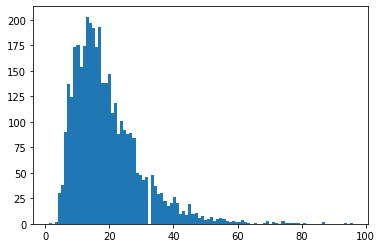

In [142]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [143]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [ ]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


# DON'T USE THE BELOW BERT AND NB STUFF

In [106]:
encoded_inputs = tokenizer(batch_sentences, padding=True, is_split_into_words=True,return_tensors='tf',max_length=50)
encoded_inputs

{'input_ids': <tf.Tensor: shape=(3045, 97), dtype=int32, numpy=
array([[  101,  7443,  4015, ...,     0,     0,     0],
       [  101,   146,  3306, ...,     0,     0,     0],
       [  101,   146,  1821, ...,     0,     0,     0],
       ...,
       [  101,  1198, 11824, ...,     0,     0,     0],
       [  101,  1422,  1488, ...,     0,     0,     0],
       [  101,  1188,  1110, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3045, 97), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3045, 97), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [107]:
# separate encoder values into train/test data
# TODO update encoder with Test data as well
train_sentences = encoded_inputs['input_ids'][:2895]
test_sentences = encoded_inputs['input_ids'][-150:]

# build boolean mask to flatten all sentences into tokens
train_mask = encoded_inputs['attention_mask'][:2895]
test_mask = encoded_inputs['attention_mask'][-150:]

train_sentences = tf.boolean_mask(train_sentences, train_mask)
train_sentences = tf.reshape(train_sentences,[-1,1])
train_sentences.shape

test_sentences = tf.boolean_mask(test_sentences, test_mask)
test_sentences = tf.reshape(test_sentences,[-1,1])
test_sentences.shape

TensorShape([60156, 1])

TensorShape([3173, 1])

In [108]:
train_sentences = encoded_inputs['input_ids'][:2895]
# train_sentences = tf.boolean_mask(train_sentences, train_mask)
# train_sentences[:18]
[(ind,tokenizer.decode(sent)) for ind,sent in enumerate(train_sentences) if '#' in tokenizer.decode(sent)]

[(1330,
  '[CLS] The # 1 reason that is always repeated. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'),
 (2186,
  '[CLS] The materials that came with the computer did not include the right # anywhere. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [109]:
# train_labels = np.array([token for key, val in ae_laptop_train.items() for token in val['label']])
# test_labels = np.array([token for key, val in ae_laptop_dev.items() for token in val['label']])
label_list = ['I','O','B']

def format_labels(data_dict):
    # get the label for each sample
    convert_labels = [val['label'] for key, val in data_dict.items() ]

    # convert every token to a numerical label
    convert_labels = [[label_list.index(token) for token in label] for label in convert_labels]
    
    # add the class and sep tokens
    convert_labels_num = []
    for label in convert_labels:
        # class token
        sp_token = [1]
        sp_token.extend(label)
        # sep token
        sp_token.append(1)
        convert_labels_num.extend(sp_token)
    
#     print(convert_labels_num)
    convert_labels_num = np.array(convert_labels_num)
    return(convert_labels_num.reshape(-1))
train_labels = format_labels(ae_laptop_train)
test_labels = format_labels(ae_laptop_dev)
train_labels
train_labels.shape
test_labels
test_labels.shape

array([1, 2, 1, ..., 1, 1, 1])

(54747,)

array([1, 1, 1, ..., 1, 1, 1])

(2906,)

In [110]:
nb = MultinomialNB().fit(train_sentences, train_labels)
y_pred = nb.predict(test_sentences)


ValueError: Found input variables with inconsistent numbers of samples: [2895, 54747]

In [ ]:
accuracy_score(test_labels,y_pred)

In [ ]:

Counter([label_list[pred] for pred in y_pred])

## Play with BERT

In [ ]:
def build_model():
    in_x = tf.keras.layers.Input=(shape=(5,34), name='in_id')

In [ ]:
encoded_inputs['input_ids']

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)
model.fit(train_dataset, epochs=2, steps_per_epoch=115)

In [ ]:
bert_layer = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
bert_outputs = bert_layer(encoded_inputs)[0]

In [ ]:
dense = tf.keras.layers.Dense(256,activation='relu',name='dense')(bert_outputs)
dense = tf.keras.layers.Dropout(rate=0.1)(dense)
dense = tf.keras.layers.Dense(128,activation='relu',name='dense')(dense)
dense = tf.keras.layers.Dropout(rate=0.1)(dense)
pred = tf.keras.layers.Dense(3,activation='softmax',name='ner')(dense)

In [ ]:
predictions = tf.argmax(pred, axis=2)
predictions

In [ ]:
label_list = [
    "B","I","O"
]
[label_list[pred] for predict in predictions for pred in predict]

In [ ]:
# asc
batch_sentences = [val['sentence'] for key,val in asc_laptop_train.items()]
batch_sentences = batch_sentences[:5]
batch_sentences

In [ ]:
batch = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="tf")

In [ ]:
bert_layer = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
bert_outputs = bert_layer(batch)[0]

In [ ]:
dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_outputs)

dense = tf.keras.layers.Dropout(rate=0.1)(dense)

pred = tf.keras.layers.Dense(21, activation='softmax', name='ner')(dense)

model = tf.keras.models.Model(inputs=batch, outputs=pred)

model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                      custom_acc_orig_non_other_tokens])


model.summary()

## Play with AE baseline - NN+

In [ ]:
def pos_ae(tokenized_sentence):
    """
    Tag sentences using POS tagger and identify consecutive nouns as entities
    """
    pos_sent = tokenized_sentence.apply(lambda sent:nltk.pos_tag(sent,tagset='universal'))
    
    
    # tag with IOB terminology
    ae_tag = lambda sent:['O' if token[1] != 'NOUN' 
                          else 'B' if ((token[1]=='NOUN') & ((sent[ind-1][1]!='NOUN') | (ind==0))) 
                          else 'I' for ind,token in enumerate(sent)]

    return(pos_sent.apply(ae_tag))

# since the POS tagger is based on the words themselves and not context.
ae_laptop_dev_df['predictions'] = pos_ae(ae_laptop_dev_df['sentence'])
ae_laptop_dev_df.head()

def convert_int(tagged_tokens):
    """
    Convert B,I,O tags to integers
    """
    return(tagged_tokens.apply(lambda sent: [0 if token=='O' else 1 if token=='B' else 2 for token in sent]))

convert_int(ae_laptop_dev_df['predictions'])


## Explore AE Regex Parser - business rules

In [ ]:
# try a more sophisticated method for chunking
def regex_parser(tokenized_sentence,verbose=False):
    """
    Use a Regex Parser to provide some context around noun phrases
    """
    pos_sent = nltk.pos_tag(tokenized_sentence)
#     print(pos_sent)
#     grammar = r"""
#       NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
#           {<NNP>+}                # chunk sequences of proper nouns
#     """
    
    # Update Grammar Regex to include prepositional phrases ala Semeval annotation guidelines
    grammar = r"""
    NP: {<NN><IN><DT><NN|NNP>+}
        {<NNP><NN>}
        {<NNP>+}
        {<NN>+}
        
    """
    
    cp = nltk.RegexpParser(grammar)

    tree = cp.parse(pos_sent)
    
    if verbose: print(tree)
    
    iob = [el[2][0] for el in nltk.chunk.util.tree2conlltags(tree)]
    
    return(iob)

# print example
ae_laptop_train['15']['sentence']
regex_parser(ae_laptop_train['15']['sentence'])

print(['cover','for','the','DVD','drive'])
regex_parser(['cover','for','the','DVD','drive'])

ae_laptop_dev_df.iloc[4]['sentence']
regex_parser(ae_laptop_dev_df.iloc[4]['sentence'],verbose=True)

# since the POS tagger is based on the words themselves and not context.
ae_laptop_dev_df['predictions_1'] = ae_laptop_dev_df['sentence'].apply(lambda x: regex_parser(x))
ae_laptop_dev_df.head()


## Explore AE evaluation - CE

Haven't seen many papers using CE

In [ ]:
# only using 0,1 because there aren't many very large token phrases
log_loss(convert_int(pd.DataFrame(ae_laptop_dev_df.iloc[0]['label'])),convert_int(pd.DataFrame(ae_laptop_dev_df.iloc[0]['predictions'])),labels=[0,1])

## Explore AE evaluation - SemEval14

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/  
- partial boundary match over the surface string

In [ ]:
# TODO need to explore how we want to move forward with all sentences rather than just 1.
# Should try to implement the SemEval14 evaluation criteria bc this is best practice

In [ ]:
# TODO amend this tree structure for all predictions as well
print('\nGold Standard:')
# tag every sentence with the pos
gold_tree = ae_laptop_dev_df['sentence'].apply(lambda x: nltk.pos_tag(x))
print(gold_tree)
iob_gold_tree = [nltk.Tree('S',
                           [(el[0], el[1], ae_laptop_dev_df.iloc[tree_ind]['label'][ind])
                            if ae_laptop_dev_df.iloc[tree_ind]['label'][ind]=='O'
                            else (el[0], el[1], ae_laptop_dev_df.iloc[tree_ind]['label'][ind] + '-NP')
                            for ind,el in enumerate(tree)])
                for tree_ind, tree in enumerate(gold_tree)]
ae_laptop_dev_df['iob_gold_tree'] = iob_gold_tree
ae_laptop_dev_df.head()

In [ ]:
def get_entities(sentence_lst, predictions_lst):
    """
    Reformat the IOB structure to get the actual entities from the sentence
    """
    
    # for every sentence, iterate through
    all_entities = []
    for sample in range(len(predictions_lst)):
    
        # get indices where entities are identified
        predictions = np.array(predictions_lst[sample])
        ind = (predictions == 'B') | (predictions == 'I')
        
        # create list of numerical indices and boolean indices. ex. [(4, True), (10, True), (11, True), (15, True)]
        ind_tuple = [num_ind for num_ind in list(enumerate(ind)) if num_ind[1]==True]
        
        # get the sentence of interest. identify what these entities are
        sentence = np.array(sentence_lst[sample])

        # group the phrases together
        entities = []
        for subset,num_ind_tuple in zip(sentence[ind], ind_tuple): # [('price', (4, True)), ('netbook', (10, True)), ('*', (11, True)), ('machine', (15, True))]
            # put the B in entities
            if predictions[num_ind_tuple[0]][0] == 'B':
                entities.append([subset])
            # if the tag is I, add to the last item of the list
            elif predictions[num_ind_tuple[0]][0] == 'I':
                last_entry = entities.pop()
                last_entry.append(subset)
                entities.append(last_entry)
            # there should not be any 'O' indices here
            else:
                print('Error')
        all_entities.append(entities)
    return(all_entities)

prediction_entities = get_entities(ae_laptop_dev_df.sentence,ae_laptop_dev_df.predictions)
gold_entities = get_entities(ae_laptop_dev_df.sentence,ae_laptop_dev_df.label)
prediction_entities[:5]
gold_entities[:5]

In [ ]:
def get_ae_eval_features(gold_entities,prediction_entities,verbose=False):
    # TODO need to generalize and do for all samples
    # TODO may later need to update these calculations to encompass sentence location.
    y_true_df = pd.DataFrame([[ind,sub_el] for ind,el in enumerate(gold_entities) for sub_el in el], columns=['sample_index','entity'])
    y_pred_df = pd.DataFrame([[ind,sub_el] for ind,el in enumerate(prediction_entities) for sub_el in el], columns=['sample_index','entity'])
    print('True')
    display(y_true_df.head())
    print('Pred')
    display(y_pred_df.head())

    cor = 0
    inc = 0
    par = 0
    mis = 0
    spu = 0

    for el in range(len(gold_entities)):
        if verbose:
            print('\n',el)
        true_subset = y_true_df[y_true_df.sample_index == el]
        pred_subset = y_pred_df[y_pred_df.sample_index == el]
        true_entities = set(true_subset.entity.apply(lambda x: '_'.join(x)))
        pred_entities = set(pred_subset.entity.apply(lambda x: '_'.join(x)))
        if verbose:
            print('True')
            print(true_entities)
            print('Pred')
            print(pred_entities)

        # get correct
        cor_entities = true_entities & pred_entities
        if verbose:
            print(f'Correct entities: {cor_entities}')
        cor += len(cor_entities)
        true_entities = true_entities - cor_entities
        pred_entities = pred_entities - cor_entities

        # get partial and missed
        for true in true_entities:
            # Take into account if the prediction contains a portion of the correct and if correct contains a portion of the prediction
            par_entities = set([pred for pred in pred_entities if (true in pred) | (pred in true)])
            if len(par_entities) != 0:
                if verbose:
                    print(f'Partial entities: {set([true])}')
                par += len(par_entities)
                true_entities = true_entities - set([true])
                pred_entities = pred_entities - par_entities
            else:
                if verbose:
                    print(f'Missed entities: {set([true])}')
                mis += 1
                true_entities = true_entities - set([true])

        if len(true_entities) == 0:
            if verbose:
                print(f'Spurious entities: {pred_entities}')
            spu += len(pred_entities)
        else:
            print('Error')

    print(f'\nCorrect: {cor}')
    print(f'Partial: {par}')
    print(f'Missed: {mis}')
    print(f'Spurious: {spu}')
    return(cor,par,mis,spu,inc)
cor,par,mis,spu,inc = get_ae_eval_features(gold_entities,prediction_entities,verbose=False)

In [ ]:
def get_ae_eval(sentence_lst, y_true, y_pred,verbose=False):
    """
    Get entity recognition evaluations accoridng to the partial match SemEval strategy
    """
    prediction_entities = get_entities(sentence_lst,y_pred)
    gold_entities = get_entities(sentence_lst,y_true)
    
    cor,par,mis,spu,inc = get_ae_eval_features(gold_entities,prediction_entities,verbose=verbose)
    
    pos_eval = cor + inc + par + mis
    act_eval = cor + inc + par + spu

    precision = (cor + .5 * par) / act_eval
    recall = (cor + .5 * par) / pos_eval
    f1 = ( 2* precision * recall) / (precision + recall)
    
    print(f'\nPrecision: \t{precision}')
    print(f'Recall: \t{recall}')
    print(f'F1-Score: \t{f1}')
    return(precision, recall, f1)

get_ae_eval(ae_laptop_dev_df.sentence,ae_laptop_dev_df.label,ae_laptop_dev_df.predictions)

In [ ]:
get_ae_eval(ae_laptop_dev_df.sentence,ae_laptop_dev_df.label,ae_laptop_dev_df.predictions_1)

## Explore AE evaluation - ChunkScore
https://stackoverflow.com/questions/17325554/difference-between-iob-accuracy-and-precision  
Somehow, this is not working.

In [ ]:
# TODO get ChunkScore to work
tokenized_sentence = ae_laptop_train['15']['sentence']
pos_sent = nltk.pos_tag(tokenized_sentence)

##
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
      {<NNP>+}                # chunk sequences of proper nouns
"""
cp = nltk.RegexpParser(grammar)

tree = cp.parse(pos_sent)

iob = [el[2][0] for el in nltk.chunk.util.tree2conlltags(tree)]

print('Prediction:')
print(tree)
nltk.chunk.util.tree2conlltags(tree)
regex_parser(ae_laptop_train['15']['sentence'])
##

gold_tree = pos_sent
print('\nGold Standard:')
# create the tree with IOB input
iob_gold_tree = nltk.Tree('S',[(el[0], el[1], ae_laptop_train['15']['label'][ind]) if ae_laptop_train['15']['label'][ind]=='O' 
                               else (el[0], el[1], ae_laptop_train['15']['label'][ind] + '-NP')for ind,el in enumerate(gold_tree)])
print(nltk.chunk.util.conlltags2tree(iob_gold_tree))
# print(nltk.chunk.util.conlltags2tree([(el[0], el[1], ae_laptop_train['15']['label'][ind])for ind,el in enumerate(gold_tree)]))
# print(nltk.chunk.util.conlltags2tree())
print(cp.evaluate([iob_gold_tree]))

# nltk.chunk.util.tagstr2tree(' '.join(tokenized_sentence), chunk_label='NP', root_label='S', sep='/')

In [ ]:
# TODO get ChunkScore to work on all dev
print('\nGold Standard:')
# tag every sentence with the pos
gold_tree = ae_laptop_dev_df['sentence'].apply(lambda x: nltk.pos_tag(x))
print(gold_tree)
iob_gold_tree = [nltk.Tree('S',
                           [(el[0], el[1], ae_laptop_dev_df.iloc[tree_ind]['label'][ind])
                            if ae_laptop_dev_df.iloc[tree_ind]['label'][ind]=='O'
                            else (el[0], el[1], ae_laptop_dev_df.iloc[tree_ind]['label'][ind] + '-NP')
                            for ind,el in enumerate(tree)])
                for tree_ind, tree in enumerate(gold_tree)]
ae_laptop_dev_df['iob_gold_tree'] = iob_gold_tree
ae_laptop_dev_df.head()

## Explore AE evaluation - Token Accuracy

In [ ]:
def get_accuracy(true,predictions):
    accuracy = []
    for true_el, predict_el in zip(true,predictions):
        accuracy.append((np.array(predict_el) == np.array(true_el)).sum() / (len(true_el)))
    return(accuracy)

ae_laptop_dev_df['accuracy'] = get_accuracy(ae_laptop_dev_df.label,ae_laptop_dev_df.predictions)
ae_laptop_dev_df['accuracy_1'] = get_accuracy(ae_laptop_dev_df.label,ae_laptop_dev_df.predictions_1)
ae_laptop_dev_df.head()
ae_laptop_dev_df[['accuracy','accuracy_1']].describe()

## Export samples that are well / poorly extracted

In [ ]:
def get_bad_examples(n = 1):
    ind = np.argpartition(ae_laptop_dev_df.accuracy + ae_laptop_dev_df.accuracy_1,n)[:n]
    print(ind)
    sort_ind = ind[np.argsort((ae_laptop_dev_df.accuracy + ae_laptop_dev_df.accuracy_1).iloc[ind])]
    bad_example = ae_laptop_dev_df.iloc[sort_ind]
    
    display(bad_example)
    print(*[' '.join(sent) for sent in bad_example.sentence],sep='\n')
    
get_bad_examples(3)

def get_good_examples(n = 1):
    ind = np.argpartition(ae_laptop_dev_df.accuracy + ae_laptop_dev_df.accuracy_1,-n)[-n:]
    print(ind)
    sort_ind = ind[np.argsort((ae_laptop_dev_df.accuracy + ae_laptop_dev_df.accuracy_1).iloc[ind])]
    good_example = ae_laptop_dev_df.iloc[sort_ind]
    
    display(good_example)
    print(*[' '.join(sent) for sent in good_example.sentence],sep='\n')
# good_example = ae_laptop_dev_df.iloc[np.argmax(ae_laptop_dev_df.accuracy + ae_laptop_dev_df.accuracy_1)]
get_good_examples(3)

## Play with ASC baseline

In [115]:
def vader_asc(sentence_lst):
    """
    For every sentence in the list, tag it as a positive/negative sentiment based on the sum of the words.
    """
    analyzer = SentimentIntensityAnalyzer()
    pos_neg_tag_lst = []
    for ind,sentence in enumerate(sentence_lst):
        vs = analyzer.polarity_scores(sentence)
        pos_neg_tag = 'negative' if vs['compound'] <= -0.05 else 'positive' if vs['compound'] >= 0.05 else 'neutral' 
        # print first 10 examples
        if ind <10: print("{:-<65} {} ({})".format(sentence, str(vs['compound']),pos_neg_tag))
        pos_neg_tag_lst.append(pos_neg_tag)
    return(pos_neg_tag_lst)

asc_laptop_dev_df['predictions'] = vader_asc(asc_laptop_dev_df.sentence)

Not even safe mode boots.---------------------------------------- -0.3412 (negative)
Keyboard was also very nice and had a solid feel.---------------- 0.5709 (positive)
Keyboard is plastic and spongey feeling.------------------------- 0.128 (positive)
I would recommend this laptop to anyone looking to get a new laptop who is willing to spend a little more money to get great quality! 0.784 (positive)
Thus, when you carry it at a slanted angle, the screen will "topple" or "slide" down, if you understand what I mean. 0.0 (neutral)
When I called Sony the Customer Service was Great.--------------- 0.6249 (positive)
I also did not like the loud noises it made or how the bottom of the computer would get really hot. -0.2755 (negative)
I also did not like the loud noises it made or how the bottom of the computer would get really hot. -0.2755 (negative)
Also, one of the users mentioned how the edges on the macbook is sharp, if you have money to spend on one of the incase shells, it doesn't seem 

## Explore ASC evaluation - accuracy

In [ ]:
asc_laptop_dev_df.head()
(asc_laptop_dev_df.polarity == asc_laptop_dev_df.predictions).value_counts(normalize=True)
accuracy_score(asc_laptop_dev_df.polarity,asc_laptop_dev_df.predictions)

## Explore ASC evaluation - Confusion Matrix

In [ ]:
print(confusion_matrix(asc_laptop_dev_df.polarity,asc_laptop_dev_df.predictions,labels=['negative','neutral','positive']))

## Explore ASC evaluation - Classification Report

In [ ]:
print(classification_report(asc_laptop_dev_df.polarity,asc_laptop_dev_df.predictions,labels=['negative','neutral','positive']))

## Combine ASC evaluation

In [ ]:
def get_asc_eval(y_true, y_pred):
    print(confusion_matrix(y_true,y_pred,labels=['negative','neutral','positive']))
    print(classification_report(y_true,asc_laptop_dev_df.predictions,labels=['negative','neutral','positive']))